Archivos monitor encontrados:



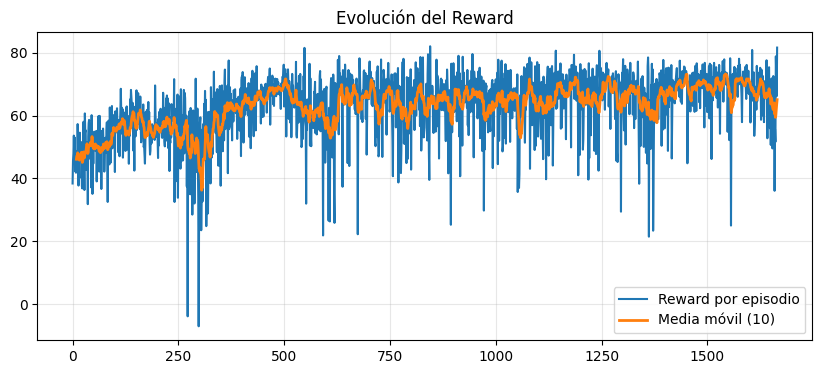

Estadísticas:
count    1666.000000
mean       62.859923
std        10.403889
min        -7.080213
25%        56.755394
50%        65.315485
75%        70.376819
max        82.072525
Name: r, dtype: float64


/tmp/ipykernel_30394/4266584621.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actions.append(int(action))


Distribución de acciones:
  Acción 0: 675 veces (33.8%)
  Acción 2: 240 veces (12.0%)
  Acción 3: 22 veces (1.1%)
  Acción 4: 1059 veces (53.0%)
  Acción 6: 4 veces (0.2%)


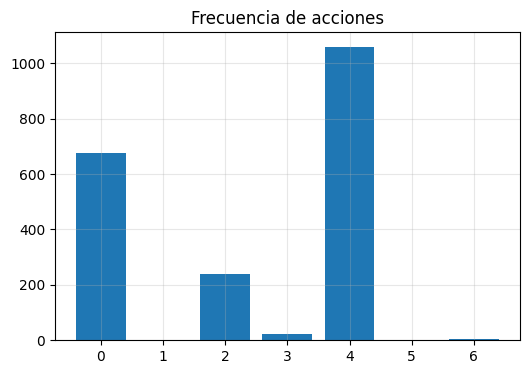

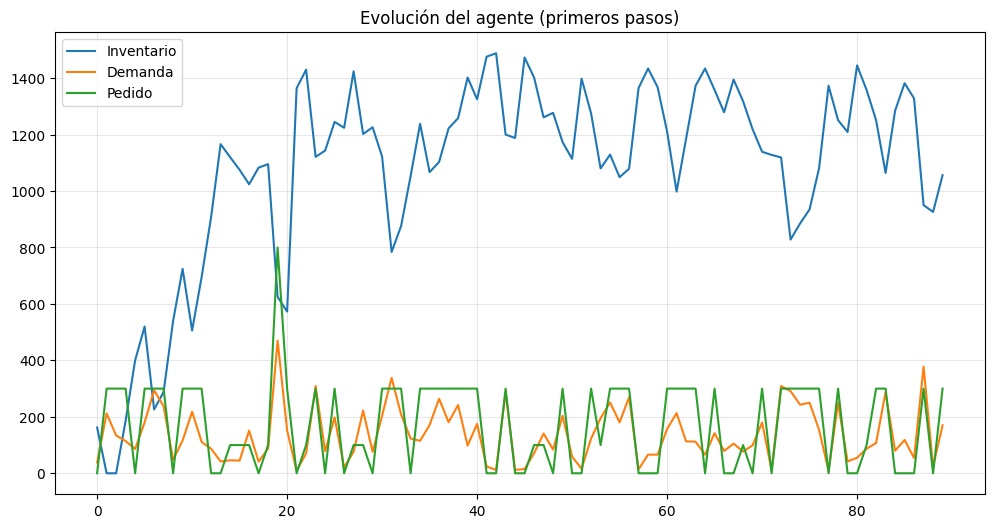

No hay NaNs en primeras 1500 transiciones.


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.environment_dqn import RetailEnvDQN

output_path = '../results/plots/dqn/' # Para guardar los plots
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Detectando archivos monitor
def check_monitor_files(path):
    """
    Encuentra archivos monitor_train_*.csv*, monitor_eval_*.csv*.
    Soporta archivos tipo "monitor_train_0.csv.monitor.csv".
    """

    # Detecta cualquier archivo que COMIENCE con monitor_ y tenga extensión .csv*
    files = glob.glob(os.path.join(path, "**/monitor_*.csv*"), recursive=True)

    if not files:
        print("No se encontraron archivos monitor_*.csv*")
        return None

    train_files, eval_files = [], []
    print("Archivos monitor encontrados:\n")

    for f in files:
        if "monitor_train" in f:
            train_files.append(f)
        elif "monitor_eval" in f:
            eval_files.append(f)

    return {
        "train": sorted(train_files),
        "eval": sorted(eval_files),
        "all": sorted(train_files + eval_files),
    }

# Grafica los rewards por episodio
def plot_episode_rewards(monitor_csv_path):
    try:
        df = pd.read_csv(monitor_csv_path, skiprows=1)
    except:
        print(f"Error leyendo {monitor_csv_path}")
        return

    if "r" not in df.columns:
        print("Archivo inválido: no tiene columna 'r'")
        return

    rewards = df["r"]

    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label="Reward por episodio")
    plt.plot(rewards.rolling(10).mean(), label="Media móvil (10)", linewidth=2)
    plt.title("Evolución del Reward")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(output_path + 'rewards.png')
    plt.show()

    print("Estadísticas:")
    print(rewards.describe())

# Distribución de acciones
def check_action_distribution(model, env, n_steps=2000):
    obs = env.reset()
    actions = []

    for _ in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        actions.append(int(action))
        obs, _, done, _ = env.step(action)
        if done:
            obs = env.reset()

    actions = np.array(actions)
    unique, counts = np.unique(actions, return_counts=True)

    print("Distribución de acciones:")
    for u, c in zip(unique, counts):
        print(f"  Acción {u}: {c} veces ({100*c/len(actions):.1f}%)")

    plt.figure(figsize=(6, 4))
    plt.bar(unique, counts)
    plt.title("Frecuencia de acciones")
    plt.grid(True, alpha=0.3)
    plt.savefig(output_path + 'actions_dist.png')
    plt.show()

# Visualizar comportamiento del agente
def visualize_behavior(model, env, steps=300):
    obs = env.reset()

    inv_list, demand_list, order_list = [], [], []

    for _ in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        info = info[0]

        inv_list.append(info.get("inventario", np.nan))
        demand_list.append(info.get("demanda", np.nan))

        qty = env.envs[0].env.action_values[int(action[0])]
        order_list.append(qty)

        if done:
            break

    plt.figure(figsize=(12, 6))
    plt.plot(inv_list, label="Inventario")
    plt.plot(demand_list, label="Demanda")
    plt.plot(order_list, label="Pedido")
    plt.title("Evolución del agente (primeros pasos)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(output_path + 'evolution.png')
    plt.show()

# Detectar NaNs
def check_for_nans(env, steps=1500):
    obs = env.reset()

    for i in range(steps):
        if np.isnan(obs).any():
            print(f"NaN en OBS en step {i}")
            return False

        obs, reward, done, info = env.step([0])

        if np.isnan(reward).any():
            print(f"NaN en REWARD en step {i}")
            return False

        if done:
            obs = env.reset()

    print("No hay NaNs en primeras 1500 transiciones.")
    return True

# Ejecutar Sanity Checks
def run_sanity_checks(experiment_dir=None):
    monitors = check_monitor_files(experiment_dir)
    if not monitors or not monitors["train"]:
        print("No se encontraron monitores de entrenamiento.")
        return
    monitor_train = monitors["train"][0]
    plot_episode_rewards(monitor_train)
    
    # El modelo tiene dos opciones
    best_model_path = os.path.join(experiment_dir, "best_model", "best_model.zip")
    final_model_path = os.path.join(experiment_dir, "model_final", "dqn_final.zip")
    # Cargando dataset y entorno
    df = pd.read_csv("../data/data_train.csv")
    data_array = df.values.astype(np.float32)

    split_idx = int(len(data_array) * 0.8)
    test_data = data_array[split_idx:]

    env = DummyVecEnv([lambda: Monitor(RetailEnvDQN(test_data))])

    # Cargando el modelo
    model_path = best_model_path
    model = DQN.load(model_path, env=env)

    # Distribución de acciones
    check_action_distribution(model, env)
    # Visualización del comportamiento
    visualize_behavior(model, env)
    check_for_nans(env)


if __name__ == "__main__":
    run_sanity_checks("../results/models/dqn/")